In [ ]:

import pandas as pd
import numpy as np
df=pd.read_csv("/content/FINAL_DATA2.csv")
df.cleanData=df.cleanData.astype(str)

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 4.4 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3126823 sha256=b943cebc6a25e459af104d004aff5d2fd8cca1e0a16831ffc5e069d9a08088c8
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
#df['word_length'] = df['cleanData'].apply(lambda x:len(x.split()))
df.dtypes

twitter_id             int64
content               object
location              object
search_word            int64
word_length            int64
cleanData             object
location_extracted    object
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.cleanData,df.search_word, test_size = 0.2, stratify = df.search_word,random_state = 30)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
df_total

1168                       hindu religious tradition dest
2250                       injure mumbai slum house crash
858                                       thank keep safe
2390                                         singh victor
1505    today chandigarhtrafficpolice conduct covid am...
                              ...                        
409     two day birthday panchkula major anuj rajput d...
2345    makeroadssafe not government responsibility ev...
678     free amp quality healthcare medicine test oper...
294                                    sir thank feedback
1014    happy birthday city beautiful chandigarh good ...
Name: cleanData, Length: 2462, dtype: object

In [ ]:
len(tokenizer.word_index)

3664

In [ ]:
df.word_length.max()

28

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=171,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 171, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(1969, 171) (493, 171)


In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in ft.words:
            gensim_weight_matrix[index] = ft[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

In [ ]:
gensim_weight_matrix[:10]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21956393,  0.04876548,  0.16747907, ...,  0.16038254,
         0.14348492, -0.13686517],
       [ 0.06755968,  0.01380814,  0.12010717, ...,  0.06396101,
        -0.02703606,  0.01557534],
       ...,
       [ 0.04202888,  0.00409665,  0.06703693, ..., -0.01205727,
        -0.00494438, -0.07276614],
       [ 0.00405344, -0.35222372,  0.12422295, ...,  0.049962  ,
        -0.20711023, -0.18537791],
       [-0.00701304,  0.04581201,  0.03699597, ...,  0.04028849,
        -0.02061738,  0.02846464]])

In [ ]:
print(gensim_weight_matrix.shape)
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

(10000, 300)


In [ ]:
EMBEDDING_DIM = 300 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(300,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(300,return_sequences=False)))
model_gensim.add(Dense(3, activation = 'softmax'))
model_gensim.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
model_gensim.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 171, 300)          3000000   
                                                                 
 dropout_12 (Dropout)        (None, 171, 300)          0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 171, 600)         1444800   
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 171, 600)          0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 171, 800)         3206400   
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 171, 800)         

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 60, batch_size = 250, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )

Epoch 1/60
8/8 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7816
Epoch 00001: val_accuracy improved from -inf to 0.84584, saving model to ./model_gensim.h5
8/8 [==============================] - 32s 3s/step - loss: 0.6223 - accuracy: 0.7816 - val_loss: 0.4067 - val_accuracy: 0.8458
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8751
Epoch 00002: val_accuracy improved from 0.84584 to 0.90467, saving model to ./model_gensim.h5
8/8 [==============================] - 19s 2s/step - loss: 0.3532 - accuracy: 0.8751 - val_loss: 0.2670 - val_accuracy: 0.9047
Epoch 3/60
8/8 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9172
Epoch 00003: val_accuracy improved from 0.90467 to 0.93103, saving model to ./model_gensim.h5
8/8 [==============================] - 19s 2s/step - loss: 0.2588 - accuracy: 0.9172 - val_loss: 0.2427 - val_accuracy: 0.9310
Epoch 4/60
8/8 [==============================] - ETA: 0s - loss

In [ ]:
model_gensim.evaluate(X_test_pad, y_test) 

16/16 [==============================] - 3s 204ms/step - loss: 0.2202 - accuracy: 0.9452


[0.22017468512058258, 0.9452332854270935]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

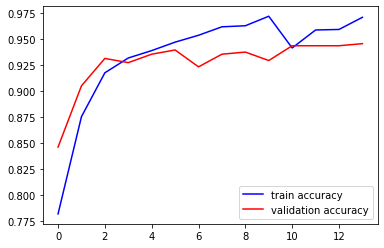

In [ ]:
plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
new_complaint = ['There is too much traffic on road which has caused jam from sector 32 to sector 36']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=171,padding='post')
pred = model_gensim.predict(padded)
labels = ['Accident','Traffic','Potholes']
print(pred, labels[np.argmax(pred)])

[[1.7515969e-03 9.9814653e-01 1.0190821e-04]] Traffic


In [ ]:
from sklearn.metrics import classification_report

y_pred=model_gensim.predict(X_test_pad)
predicted = np.argmax(y_pred, axis=1)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83        66
           1       0.96      0.98      0.97       418
           2       0.80      0.44      0.57         9

    accuracy                           0.95       493
   macro avg       0.88      0.74      0.79       493
weighted avg       0.94      0.95      0.94       493

